# Constrained optimization: equality constraints
### Peter Weber

### Libraries

In [300]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib
%matplotlib inline

### Helpers

In [328]:
def newton_descent(x0, ak, gradL_fct, desc_dir, max_iter = 1e4, threshold = 1e-6):
    iter_ = 0
    xk = x0
    x_iter = list()
    grad_iter = list()
    grad_iter.append(gradL_fct(xk[0], xk[1], xk[2]))
    x_iter.append(xk)
    while iter_ <= max_iter:
        gradL_current = gradL_fct(xk[0], xk[1], xk[2])
        xk = xk + ak * desc_dir(xk[0],xk[1],xk[2])
        gradL_next = gradL_fct(xk[0], xk[1], xk[2])
        grad_iter.append(gradL_next)
        x_iter.append(xk)
        if np.linalg.norm(gradL_current) - np.linalg.norm(gradL_next) <= 0 and \
                                    (gradL_current - gradL_next).all() < threshold:
            print("The algorithm has converged after", iter_ + 1, "iterations!!!")
            break
        if iter_ == max_iter:
            print("The algorithm has NOT converged after", max_iter, "iterations!!!")
        iter_ += 1
    return(np.asarray(x_iter), np.asarray(grad_iter))

def compute_grad_update(xk,ak,fct,grad_fct, compute_current = True, normalize_grad = True):
    next_step = xk - ak * grad_fct(xk[0],xk[1])    
    fct_next = fct(next_step[0], next_step[1])
    if compute_current:
        fct_current = fct(xk[0], xk[1])
        return(next_step, fct_next, fct_current)
    return(next_step, fct_next)
        
def grad_backtracking(x0, fct, grad_fct, max_iter = 1e4, tol_fct = 1e-6, tol_a = 1e-12):
    iter_ = 0
    xk = x0
    
    x_iter = list()
    loss_iter = list()
    x_iter.append(xk)
    loss_iter.append(fct(xk[0], xk[1]))
    
    while iter_ < max_iter:        
        ak = 1
        next_step, fct_next, fct_current = compute_grad_update(xk,ak,fct,grad_fct) 
        
        if fct_next < fct_current:
            x_iter.append(next_step)
            xk = next_step
            loss_iter.append(fct(xk[0], xk[1]))
        else:
            diff = abs(fct_next - fct_current)
            if diff < tol_fct:
                print("The algorithm has converged at", xk , "after", iter_ + 1, "iterations!")
                break    
            else:
                while fct_next >= fct_current:
                    ak = ak/2
                    next_step, fct_next = compute_grad_update(xk,ak,fct,grad_fct,False)
                    diff = abs(fct_next - fct_current)
                    if diff < tol_fct or ak < tol_a:
                        break
                if diff < tol_fct or ak < tol_a:
                    print("The algorithm has converged at", xk , "after", iter_ + 1, "iterations!")
                    break
                x_iter.append(next_step)
                xk = next_step
                loss_iter.append(fct(xk[0], xk[1]))
        iter_ += 1
        if iter_ == max_iter:
            print("Algorithm has NOT converged after", max_iter,"iterations!!")
    return(np.asarray(x_iter), loss_iter, ak)

The exercise consists in applying sequential quadratic programming to solve the optimization problem

$$
\textrm{minimize} ~~~ f(x_1, x_2) = e^{3x_1} + e^{-4x_2} \\
\textrm{subject to} ~~~ h(x_1, x_2) = x_1^2 + x_2^2 - 1 = 0
$$

where the solution to this problem is $(x_1^*, x_2^*) \approx (-0.748, 0.663)$, which is a saddle point.

## First exercise
Simple Newton method with constant $\alpha^k = 1$ and update of initial point. Stopping condition over $\nabla_x L$.

In [318]:
# Left Hand Side matrix of Equation 2
def LHS(x1, x2, lamb):
    lhs = np.array([[9*np.exp(3*x1) - 2*lamb, 0                        , -2*x1],
                    [0                      , 16*np.exp(-4*x2) - 2*lamb, -2*x2],
                    [-2*x1                  , -2*x2                    , 0]]
                  )
    return(lhs)

# Right Hand Side vector of Equation 2
def RHS(x1, x2, lamb):
    rhs = np.array([-3*np.exp(3*x1) + 2*lamb*x1, 
                    4*np.exp(-4*x2) + 2*lamb*x2, 
                    x1**2 + x2**2 - 1])
    return(rhs)

# Hessian of the Lagrangian
def hessL(x1, x2, lamb):
    a = np.array([9*np.exp(3*x1) - 2*lamb, 0 ],
                 [0                      , 16*np.exp(-4*x2) - 2*lamb])
    return(a)

# Gradient of the Lagrangian
def gradL(x1, x2, lamb):
    a = np.array([3*np.exp(3*x1) - 2*lamb*x1, -4*np.exp(-4*x2) - 2*lamb*x2])
    return(a)

# Descent direction
def newton_dir(x1,x2,lamb):
    descent = np.linalg.solve(LHS(x1, x2, lamb), RHS(x1, x2, lamb))
    return(descent)

Before we start evaluating the first exercise, we double check the solution of Eq. 2 to make sure that both sides of the linear system are correct. We use the starting points as given in the assignment sheet.

In [319]:
# Starting points
x0 = np.array([-1,1])
lamb0 = -1

# Linear system Eq. 2
solution = np.linalg.solve(LHS(x0[0], x0[1], lamb0), RHS(x0[0], x0[1], lamb0))
print("We obtain" 
      "\nd_1^0 =", round(solution[0],5),
      "\nd_2^0 =", round(solution[1],5),
      "\nnu^0 =", round(solution[2],5),
      "\nas in the assignment!")

We obtain
d_1^0 = 0.22577 
d_2^0 = -0.27423 
nu^0 = 0.64896 
as in the assignment!


Next, we perform the simple Newton descent with the initial values $(x_1^0, x_2^0) = (-1,1)$ and $\lambda_0 = -1$ as proposed in the assignment. We will see that the method converges very quickly to a point where the gradient of the Lagrangian with respect to $x$ approaches zero (the stopping criterion).

In [320]:
x0_ = np.r_[x0, lamb0]
ak = 1
xk_iter, gradL_iter = newton_descent(x0_, ak, gradL, newton_dir)
print("It converged at the point", xk_iter[-1,:])

The algorithm has converged after 6 iterations!!!
It converged at the point [-0.74833549  0.66332043 -0.21232494]


## Second exercise
Simple Newton method with different starting points, to figure out how the method performs for starting points that are further away from the minimum.

In [357]:
num_starting_points = 5

x_start = [np.r_[np.random.uniform(-6, 6) ,np.random.uniform(-6, 6), np.random.uniform(-6,6)]\
           for i in range(num_starting_points)]

for x in x_start:
    ak = 1
    print("\nStarting point (x1, x2, lambda) =", x)
    _ , __ = newton_descent(x, ak, gradL, newton_dir)
    print("It converged at the point", _[-1,:])


Starting point (x1, x2, lambda) = [ 5.93475632  1.80254254 -4.68847174]
The algorithm has converged after 21 iterations!!!
It converged at the point [ 0.99498259 -0.10004825 29.82786165]

Starting point (x1, x2, lambda) = [-1.59022423 -4.46283287 -0.08429367]
The algorithm has converged after 23 iterations!!!
It converged at the point [-0.74833549  0.66332043 -0.21232494]

Starting point (x1, x2, lambda) = [-3.6036366  -3.23282687 -3.5108113 ]
The algorithm has converged after 14 iterations!!!
It converged at the point [ 0.91041323 -0.41370006 25.2938552 ]

Starting point (x1, x2, lambda) = [-3.27096657  4.61593681 -0.99008868]
The algorithm has converged after 11 iterations!!!
It converged at the point [-0.74833549  0.66332043 -0.21232494]

Starting point (x1, x2, lambda) = [-4.97434132  4.34113676  0.41275575]
The algorithm has converged after 11 iterations!!!
It converged at the point [-0.74833549  0.66332043 -0.21232494]


As can be seen, the algorithm does not always find the optimum. This occurs when the initial point is far away from the optimal point.

## Third exercise
In this part of the exercise we will use a merit function as a kind of cost function to find a solution close to the optimum. The merit function is chosen as

$$
M(x_1, x_2) = f(x_1, x_2) + \rho h(x_1, x_2)^2
$$

where $\rho$ is a positive number. Here we will use $\rho = 10$.

In [331]:
def merit_fct(x1,x2):
    y = np.exp(3*x1) + np.exp(-4*x2) + 10*(x1**2 + x2**2 - 1)**2
    return(y)

def grad_merit(x1,x2):
    f1 = 3*np.exp(3*x1) + 40*x1*(x1**2 + x2**2 - 1)
    f2 = -4*np.exp(-4*x2) + 40*x2*(x1**2 + x2**2 - 1)
    return(np.r_[f1,f2])

To get some insight about the Merit function we plot its contours and then the function itself. This will help in understanding how to deal with it, as the function very quickly due the exponenents in $f(x_1, x_2)$.

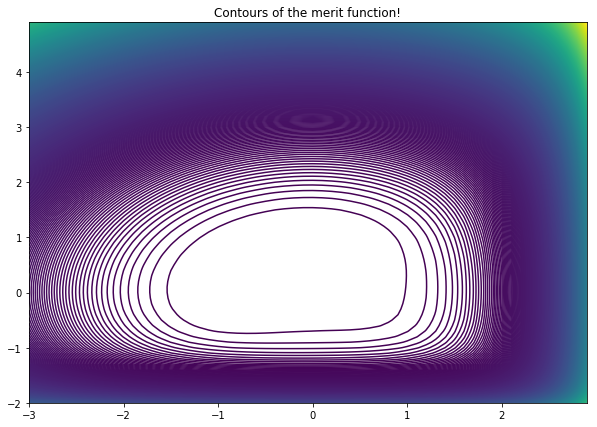

In [358]:
X = np.arange(-3, 3, 0.1)
Y = np.arange(-2, 5, 0.1)
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,7))
plt.contour(X,Y,merit_fct(X,Y), 1000)
plt.title("Contours of the merit function!")
plt.show()

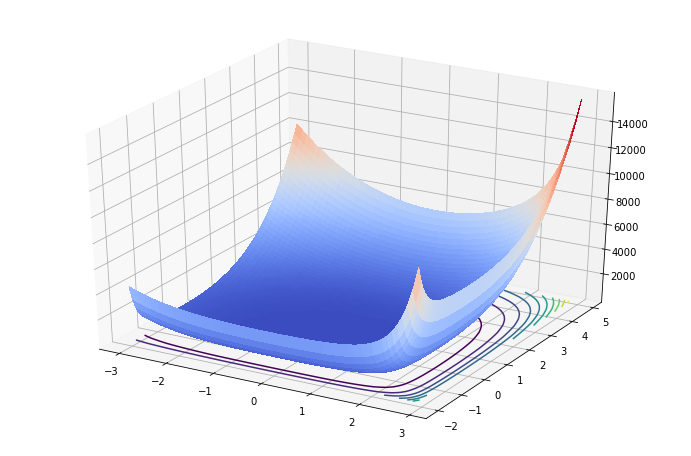

In [359]:
def plot_2d(x,y,z, offset_):
    fig = plt.figure(figsize = [12,8])
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
    ax.contour(x,y,z,10,zdir='z',offset=offset_)
    plt.show()
    
plot_2d(X,Y,merit_fct(X,Y), 0)

Here one can see that the function has a very particular shape once $x_1$ or $x_2$ grow above values of 3 or 4, respectively. This leads to huge gradients and therefore we choose the stopping criterion for the step size $\alpha^k$ in the backtracking algorithm to be as small as $10^{-12}$.

### First part 
#### (a) Compute the search direction using a gradient descent-like approach.
#### (b) Compute the value of $\alpha^k$ using the backtracking algorithm using the merit function
#### (c) Perform the update using Eq. 1

The implementation follows in the next two subsections.

### Second part
#### (a) Implement the minimization method using the Merit function without the additional Newton method. Does the method arrive to the same minimum as the previous Newton method?

In [360]:
final_points_merit = list()

for x in x_start:
    print("\nStarting point (x1, x2) =", x[:2])
    value, merit, ak = grad_backtracking(x[:2].copy(), merit_fct, grad_merit)
    final_points_merit.append(value[-1,:])
    print("The merit function has value", merit[-1], "at the final point!")
    print("The value of alpha^k at this point is:",ak)


Starting point (x1, x2) = [5.93475632 1.80254254]
The algorithm has converged at [-0.7578606   0.66054235] after 88 iterations!
The merit function has value 0.17528767569660234 at the final point!
The value of alpha^k at this point is: 0.0625

Starting point (x1, x2) = [-1.59022423 -4.46283287]
The algorithm has converged at [-0.74716094  0.67210785] after 99 iterations!
The merit function has value 0.1752839546844348 at the final point!
The value of alpha^k at this point is: 0.03125

Starting point (x1, x2) = [-3.6036366  -3.23282687]
The algorithm has converged at [-0.74799934  0.67177763] after 91 iterations!
The merit function has value 0.17527494642620078 at the final point!
The value of alpha^k at this point is: 0.03125

Starting point (x1, x2) = [-3.27096657  4.61593681]
The algorithm has converged at [-0.74736969  0.67234781] after 16 iterations!
The merit function has value 0.17528285201007734 at the final point!
The value of alpha^k at this point is: 0.0625

Starting point (

The method arrives to a point very close to the minimum (in both directions $x_1$ and $x_2$ the discrepancy is about 0.01).

#### (b) Implement the minimization method using the Merit function using the Newton method once we have approached “sufficienly” the minimum. How do you know that you have “sufficiently” approached the minimum? Do you now arrive to a better solution?

In this part of the exercise, we will use the points at which the algorithm with the merit function has converged and start the Newton iteration from there. By doing so we assume that the merit function has brought us close enough to the solution of the initial optimization problem, so that we can now use the Newton iteration to get the actual solution of the initial minimization problem.

Additionally, we use the same $\lambda$ values that we have generated in the second exercise, which were random numbers between $-6$ and $6$.

In [351]:
merit_array = np.asarray(final_points_merit)
x_array = np.asarray(x_start)

y_start = np.c_[merit_array, x_array[:,2]]

for x in y_start:
    ak = 1
    print("\nStarting point (x1, x2) =", x)
    _ , __ = newton_descent(x, ak, gradL, newton_dir)
    print("It converged at the point", _[-1,:])


Starting point (x1, x2) = [-0.76222207  0.65566151 -3.24231193]
The algorithm has converged after 7 iterations!!!
It converged at the point [-0.74833549  0.66332043 -0.21232494]

Starting point (x1, x2) = [-0.757767    0.66064221 -0.70207795]
The algorithm has converged after 6 iterations!!!
It converged at the point [-0.74833549  0.66332043 -0.21232494]

Starting point (x1, x2) = [-0.75837033  0.65997342  0.08786029]
The algorithm has converged after 5 iterations!!!
It converged at the point [-0.74833549  0.66332043 -0.21232494]

Starting point (x1, x2) = [-0.74487362  0.6747328   1.843766  ]
The algorithm has converged after 10 iterations!!!
It converged at the point [-0.74833549  0.66332043 -0.21232494]

Starting point (x1, x2) = [-0.74550357  0.67405293 -3.98947002]
The algorithm has converged after 10 iterations!!!
It converged at the point [-0.74833549  0.66332043 -0.21232494]


As can be seen, this method always converges to the right solution with a precision of more than 8-digits.